In [2]:
from collections import OrderedDict
import re
import os
import sys

sys.path.insert(0, '../')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run, get_parrallel_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "/home/ykwang/projects/LLM_Archive/GPT2/experiments/ICL_24_2/mycode/categorical_loss/models"

/home/ykwang/.conda/envs/ykwang_ICL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ykwang/.conda/envs/ykwang_ICL/lib/python3.9/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
model_name_without_label = "multiple_task_without_label"

# model_name_without_label = "multiple_task_without_label"

task_without_label = "multiple_task_without_label"

run_id_euqal_weight = "equal_weight"  # if you train more models, replace with the run_id from the table above
run_id_1over6_weight = "1over6_weight"

run_path_without_label_equal_weight = os.path.join(run_dir, model_name_without_label, run_id_euqal_weight)

run_path_without_label_1over6_weight = os.path.join(run_dir, model_name_without_label, run_id_1over6_weight)

# Plot pre-computed metrics

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [5]:
from samplers import get_data_sampler
from tasks import get_task_sampler

dwwwddddddd

In [21]:
model_without_label_euqal_weight, conf = get_parrallel_model_from_run(run_path_without_label_equal_weight)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 40

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "linear_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [17]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [18]:
model_without_label_1over6_weight, conf = get_parrallel_model_from_run(run_path_without_label_1over6_weight)

model_without_label_1over6_weight = model_without_label_1over6_weight.to(device)

with torch.no_grad():
    pred_without_label = model_without_label_1over6_weight(xs, ys)

metric_without_label = task.get_metric()
loss_without_label_1over6_weight = metric_without_label(pred_without_label, ys).cpu().numpy()



In [19]:
model_without_label_equal_weight, conf = get_parrallel_model_from_run(run_path_without_label_equal_weight)
model_without_label_equal_weight = model_without_label_equal_weight.to(device)

with torch.no_grad():
    pred_without_label = model_without_label_equal_weight(xs, ys)

metric_without_label = task.get_metric()
loss_without_label_equal_weight = metric_without_label(pred_without_label, ys).cpu().numpy()



In [39]:
pred_without_label_cat_loss[1].shape
# Getting the argmax of last dimension and reshaping.
argmax = pred_without_label_cat_loss[1].argmax(dim=-1).view(-1,1)

# Total number of elements in the tensor after reshaping.
total_elements = argmax.nelement()

# Counting the occurrence of every category and getting the percentage.
for i in range(3):
    count = (argmax == i).sum().item()
    percentage = (count / total_elements) * 100
    print(f"Percentage of {i}'s: {percentage}%")

Percentage of 0's: 93.35107421875%
Percentage of 1's: 6.571289062500001%
Percentage of 2's: 0.07763671875%


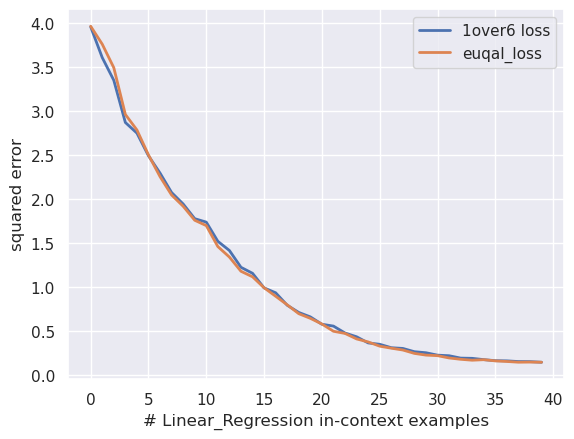

In [20]:
plt.plot(loss_without_label_1over6_weight.mean(axis=0), lw=2, label="1over6 loss")
plt.plot(loss_without_label_equal_weight.mean(axis=0), lw=2, label="euqal_loss")
# plt.plot(loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label_cat_loss")

plt.xlabel("# Linear_Regression in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [41]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 40

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "quadratic_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [42]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [43]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [44]:
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

with torch.no_grad():
    pred_with_label = model_with_label(xs, ys, 1)

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()


In [45]:
model_without_label_cat_loss, conf = get_parrallel_model_from_run(run_path_without_label_cat_loss)
model_without_label_cat_loss = model_without_label_cat_loss.to(device)

with torch.no_grad():
    pred_without_label_cat_loss = model_without_label_cat_loss(xs, ys, 1, True)

metric_without_label_cat_loss = task.get_metric()
loss_without_label_cat_loss = metric_without_label_cat_loss(pred_without_label_cat_loss[0], ys).cpu().numpy()

In [46]:
pred_without_label_cat_loss[1].shape
# Getting the argmax of last dimension and reshaping.
argmax = pred_without_label_cat_loss[1].argmax(dim=-1).view(-1,1)

# Total number of elements in the tensor after reshaping.
total_elements = argmax.nelement()

# Counting the occurrence of every category and getting the percentage.
for i in range(3):
    count = (argmax == i).sum().item()
    percentage = (count / total_elements) * 100
    print(f"Percentage of {i}'s: {percentage}%")

Percentage of 0's: 8.90087890625%
Percentage of 1's: 91.00732421875%
Percentage of 2's: 0.091796875%


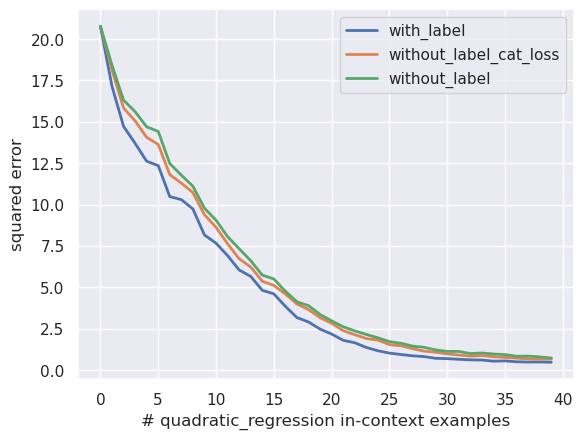

In [47]:
plt.plot(loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(loss_without_label.mean(axis=0), lw=2, label="without_label_cat_loss")
plt.plot(loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label")

plt.xlabel("# quadratic_regression in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [48]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "linear_classification",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [49]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [50]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [51]:
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

with torch.no_grad():
    pred_with_label = model_with_label(xs, ys, 2)

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()


In [52]:
model_without_label_cat_loss, conf = get_parrallel_model_from_run(run_path_without_label_cat_loss)
model_without_label_cat_loss = model_without_label_cat_loss.to(device)

with torch.no_grad():
    pred_without_label_cat_loss = model_without_label_cat_loss(xs, ys, 2, True)

metric_without_label_cat_loss = task.get_metric()
loss_without_label_cat_loss = metric_without_label_cat_loss(pred_without_label_cat_loss[0], ys).cpu().numpy()

In [53]:
pred_without_label_cat_loss[1].shape
# Getting the argmax of last dimension and reshaping.
argmax = pred_without_label_cat_loss[1].argmax(dim=-1).view(-1,1)

# Total number of elements in the tensor after reshaping.
total_elements = argmax.nelement()

# Counting the occurrence of every category and getting the percentage.
for i in range(3):
    count = (argmax == i).sum().item()
    percentage = (count / total_elements) * 100
    print(f"Percentage of {i}'s: {percentage}%")

Percentage of 0's: 2.4482421875%
Percentage of 1's: 0.0087890625%
Percentage of 2's: 97.54296875%


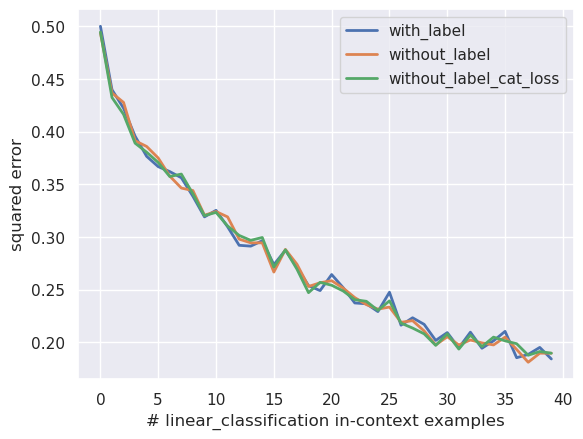

In [54]:
plt.plot(1-loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(1-loss_without_label.mean(axis=0), lw=2, label="without_label")
plt.plot(1-loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label_cat_loss")

plt.xlabel("# linear_classification in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()